# **Recommendation System : Anime**

Proyek ini bertujuan untuk mengembangkan sistem rekomendasi anime dengan mengombinasikan pendekatan **Content-Based Filtering** dan **Collaborative Filtering**.

Adapun tahapan dalam pengembangan proyek sebagai berikut :

- Data Understanding
- Exploratory Data Analysis (EDA)
- Data Preprocessing
- Data Preparation
- Model Development dengan Content Based Filtering
- Model Development dengan Collborative Filtering
- Evaluation

## Import Library

In [2]:
# Import & Install Library for Data Understanding
!pip install -q kaggle
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import zipfile
from collections import Counter

# Import Library for Data Preparation
import re
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Import Library for Model Development
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding
from tensorflow import tensordot
from tensorflow.nn import sigmoid
from keras.regularizers import l2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Import Library for Evaluation
from tensorflow.keras.metrics import RootMeanSquaredError

## **1. Data Understanding**

Data Understanding adalah tahap awal proyek untuk memahami data yang dimiliki. Dalam kasus ini, kita memiliki 2 file terpisah mengenai anime dan rating.

Pada proyek ini, dataset yang digunakan adalah Anime Recommendations Database yang tersedia secara publik di platform Kaggle. Dataset tersebut dapat diakses melalui tautan berikut:
🔗 https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database

Karena dataset yang akan digunakan bersumber dari platform Kaggle, kita perlu mengunduhnya terlebih dahulu menggunakan akun Kaggle dan API key. Berikut langkah-langkah yang perlu dilakukan:

- Upload File kaggle.json

    File ini berisi API credentials yang dapat diunduh dari halaman akun Kaggle (di bagian Account > Create API Token).

In [ ]:
# Upload File kaggle.json
files.upload()

- Konfigurasi Credential Kaggle di Environment

  Setelah file diunggah, kita perlu memindahkan file kaggle.json ke direktori yang dikenali oleh Kaggle CLI, lalu atur izin aksesnya:

In [4]:
# Konfigurasi Credential
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

- Unduh Dataset Anime Recommendations

    Setelah konfigurasi selesai, kita bisa langsung mengunduh dataset melalui platform Kaggle

In [5]:
# Unduh dataset Water Quality
!kaggle datasets download -d CooperUnion/anime-recommendations-database

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
  0% 0.00/25.0M [00:00<?, ?B/s]
100% 25.0M/25.0M [00:00<00:00, 504MB/s]


Setelah dataset terunduh, kita perlu Mengekstrak file ZIP hasil unduhan dari Kaggle.

In [6]:
# Extract zip hasil unduhan
zip_ref = zipfile.ZipFile('/content/anime-recommendations-database.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

Setelah dataset ter-ekstrak terdapat file anime.csv dan rating.csv. Selanjutnya, mari kita baca kedua data tersebut dengan menggunakan fungsi pandas.read_csv

In [7]:
# Load dataset anime dan rating
animes = pd.read_csv('/content/anime.csv')
ratings = pd.read_csv('/content/rating.csv')

# Melihat jumlah data unik di setiap file
print('Jumlah data anime: ', len(animes.anime_id.unique()))
print('Jumlah data rating yang diberikan pengguna: ', len(ratings.user_id.unique()))

Jumlah data anime:  12294
Jumlah data rating yang diberikan pengguna:  73515


## **2. Exploratory Data Analysis (EDA)**

Exploratory Data Analysis atau sering disingkat EDA merupakan proses investigasi awal pada data untuk menganalisis karakteristik, menemukan pola, anomali, dan memeriksa asumsi pada data. Teknik ini biasanya menggunakan bantuan statistik dan representasi grafis atau visualisasi.

### **2.1 Deskripsi Variabel**

Dataset ini terdiri dari dua tabel utama:

- animes: Berisi informasi metadata tentang setiap anime.

- ratings: Berisi informasi penilaian (rating) yang diberikan oleh pengguna terhadap anime.

#### 2.1.1 Dataset animes
Pertama, mari kita eksplorasi variabel **animes**, untuk mengetahui informasi pada data animes secara mendalam

In [8]:
# Melihat informasi animes
animes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


Output dari fungsi `info()` menunjukkan bahwa dataset ini memiliki **12.294** baris data dengan 7 kolom. Berikut penjelasan masing-masing variabel:

- **anime_id** *(integer)* : 	ID unik untuk setiap anime
- **name** *(object)* :	Nama atau judul anime
- **genre**	*(object)* : Genre/kategori anime (misalnya: Action, Comedy)
- **type**	*(object)* : Format anime seperti TV, Movie, OVA
- **episodes** *(object)* :	Jumlah episode
- **rating** *(float)* : Skor rata-rata penilaian pengguna
- **members**	*(integer)* :	Jumlah pengguna yang telah menambahkan anime ke daftar mereka

Selanjutnya kita akan melihat statistik pada variabel-variabel numerik yang terdapat pada data **animes** menggunakan fungsi `describe()`

In [9]:
# Menampilkan deskripsi statistik
animes.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


Berdasarkan output statistik deskriptif di atas, kita dapat memperoleh beberapa insight mengenai variabel numerik dalam dataset animes:

- **anime_id** : Data unik yang merepresentasikan **12.294 anime**
- **rating** : Skor rata-rata berkisar dari **1.67 hingga 10.0** dengan **rata-rata 6.47**
- **members** : Jumlah anggota berkisar dari **5 hingga lebih dari 1 juta**, mengindikasikan adanya anime yang sangat populer dibanding lainnya

#### 2.1.2 Dataset ratings

Selanjutnya, kita akan bereksplorasi pada variabel ratings, untuk mengetahui informasi pada data animes secara mendalam

In [10]:
# Melihat informasi ratings
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Berdasarkan output di atas, kita dapat mengetahui bahwa dataset ini memiliki jumlah entri yang sangat besar, yaitu **7.813.737** entri. Terdapat tiga variabel dalam dataset ini:

- **user_id** *(integer)* : ID unik untuk setiap pengguna
- **anime_id** *(integer)* : ID anime yang dinilai
- **rating** *(integer)* : Nilai rating dari pengguna (1–10, atau -1 jika menonton tanpa memberi nilai)

Selanjutnya kita akan melihat statistik pada variabel-variabel numerik yang terdapat pada data ratings menggunakan fungsi `describe()`

In [11]:
# Menampilkan deskripsi statistik
ratings.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


Berdasarkan output statistik deskriptif di atas, kita dapat memperoleh beberapa insight mengenai variabel numerik dalam dataset ratings:

- **user_id**: Terdapat **73.516** pengguna unik yang berinteraksi dengan data
- **anime_id**: Rating diberikan terhadap berbagai anime, dengan ID berkisar dari **1 hingga 34.519**
- **rating**: Memiliki rentang **-1 hingga 10**, dengan -1 berarti pengguna menonton namun tidak memberikan rating.

### **2.2 Missing Values dan Duplicated**

Selanjutnya kita akan melihat missing values dan duplikat pada setiap dataset yaitu `animes` dan `ratings`

#### 2.2.1 Dataset `animes`

In [12]:
# Melihat missing values
animes.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


Dari hasil diatas, dapat diperhatikan beberapa kolom yang memiliki missing values, diantaranya :    
- `genre`: **62 missing values**
- `type`: **25 missing values**
- `rating`: **230 missing values**

In [13]:
# Melihat duplikat
animes.duplicated().sum()

np.int64(0)

Berdasarkan output diatas, **tidak terdapat duplikat** pada dataset `animes`

#### 2.2.2 Dataset `ratings`

In [14]:
# Melihat missing values
ratings.isnull().sum()

,0
user_id,0
anime_id,0
rating,0


Dari hasil diatas, dapat diperhatikan bahwa **tidak ada kolom yang memiliki missing values** pada dataset `ratings`.

In [15]:
# Melihat duplikat
ratings.duplicated().sum()

np.int64(1)

Sedangkan pada pengecekan duplikat, terdapat **1 duplikat** pada dataset `ratings`

### **2.3 Distirbusi Variabel**

Untuk memahami karakteristik data lebih dalam, analisis distribusi sangat penting. Visualisasi dan histogram akan digunakan untuk menggambarkan persebaran data.

#### 2.3.1 Distribusi **Genre** pada dataset `animes`

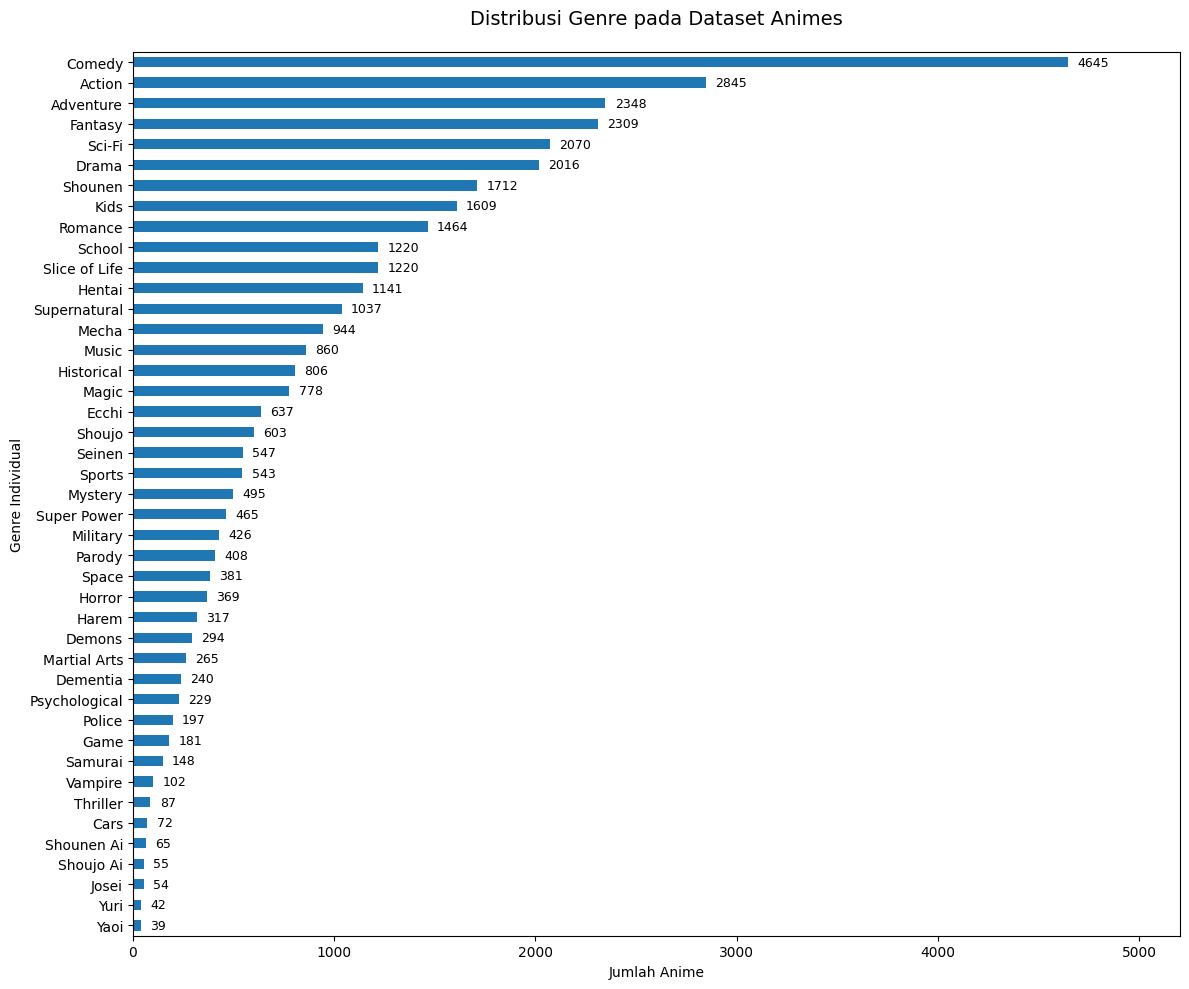

In [16]:
# Menghitung frekuensi setiap genre secara langsung
genre_counts = Counter(
    genre.strip()
    for genres_str in animes['genre'].dropna()
    for genre in genres_str.split(',')
)

# Konversi ke DataFrame
top_genres = (
    pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count'])
    .sort_values(by='count')
)

# Plot horizontal bar chart
plt.figure(figsize=(12, 10))
top_genres['count'].plot(kind='barh')

# Menambahkan label angka di ujung bar
for index, value in enumerate(top_genres['count']):
    plt.text(value + top_genres['count'].max() * 0.01, index, str(value),
             va='center', fontsize=9)

plt.title('Distribusi Genre pada Dataset Animes', fontsize=14, pad=20)
plt.xlabel('Jumlah Anime')
plt.ylabel('Genre Individual')
plt.xlim(0, top_genres['count'].max() * 1.12)
plt.tight_layout()
plt.show()

Dari grafik diatas, dapat dilihat bahwa genre **Comedy** sangat mendominasi dataset anime ini dengan jumlah anime terbanyak secara signifikan **(4645 anime)**. Genre-genre populer lainnya seperti **Action (2845)**, **Adventure (2348)**, dan **Fantasy (2309)** juga memiliki frekuensi yang tinggi dan menempati posisi teratas setelah Comedy.

#### 2.3.2 Distribusi **Rating** pada dataset `ratings`

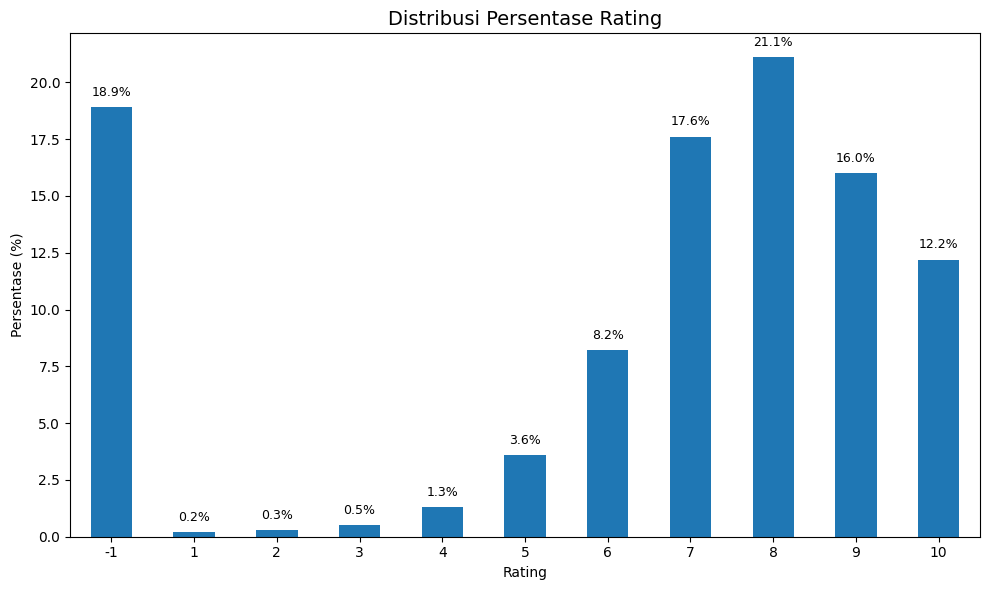

In [17]:
# Mengelompokkan data berdasarkan kolom 'rating' dan hitung jumlah entri (userId) untuk setiap rating
count_rates = ratings.groupby('rating').count()

# Menghitung persentase dari masing-masing rating terhadap total keseluruhan rating
count_rates['percent_total'] = round(count_rates['user_id'] * 100 / count_rates['user_id'].sum(), 1)

# Membuat diagram batang dari persentase rating
ax = count_rates['percent_total'].plot.bar(
    figsize=(10, 6)
)

# Menambahkan label persentase di atas setiap batang
for index, value in enumerate(count_rates['percent_total']):
    plt.text(index, value + 0.5, f'{value}%', ha='center', fontsize=9)

# Menambahkan label sumbu dan judul diagram
plt.xlabel('Rating')
plt.ylabel('Persentase (%)')
plt.title('Distribusi Persentase Rating', fontsize=14)
plt.xticks(rotation=0, ha='center')

# Menampilkan plot
plt.tight_layout()
plt.show()

Berdasarkan visualisasi diatas, terdapat beberapa Insight diantaranya:

 - **Rating -1 (18.9%)** mendominasi sebagai nilai tertinggi kedua setelah rating 8. Ini menunjukkan bahwa **sekitar 19% pengguna menonton namun tidak memberikan rating eksplisit**. Hal ini penting karena nilai ini harus dianggap sebagai missing rating, bukan rating numerik yang valid.

 - **Rating 8 (21.1%)** adalah nilai yang paling sering diberikan pengguna, diikuti oleh **rating 7 (17.6%)**, **rating 9 (16.0%)**, dan **rating 10 (12.2%)**.

 - **Rating 1 hingga 4** sangat jarang diberikan (kurang dari 2.5% secara total), mengindikasikan **positivity bias** yang kuat — pengguna lebih cenderung memberi rating tinggi atau tidak memberi rating sama sekali.

 - Distribusi membentuk pola **asimetri kanan** (right-skewed), di mana sebagian besar nilai condong ke skor tinggi.

## **3. Data Preprocessing**
Proses ini bertujuan untuk membentuk satu dataset terpadu dan bersih yang merepresentasikan hubungan antara pengguna dan anime yang mereka nilai. Langkah utama yang dilakukan dalam tahap ini adalah **Penggabungan Dataset animes dan ratings**


### Penggabungan Dataset animes dan ratings

Sebelum melakukan proses penggabungan, langkah awal yang dilakukan adalah mengurutkan dataset animes berdasarkan kolom anime_id dan dataset ratings berdasarkan kolom user_id. Pengurutan ini bertujuan untuk memastikan keteraturan data dan mempermudah proses integrasi antar kedua dataset.

In [18]:
# Mengurutkan dataset animes dan ratings
animes_df = animes.sort_values('anime_id')
ratings_df = ratings.sort_values('user_id')

In [19]:
# Menampilkan 5 baris pertama dari DataFrame animes
animes_df.head()

,anime_id,name,genre,type,episodes,rating,members
22,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
152,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,8.40,137636
214,6,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069
2095,7,Witch Hunter Robin,"Action, Drama, Magic, Mystery, Police, Superna...",TV,26,7.36,64905
3159,8,Beet the Vandel Buster,"Adventure, Fantasy, Shounen, Supernatural",TV,52,7.06,9848


In [20]:
# Menampilkan 5 baris pertama dari DataFrame ratings
ratings_df.head()

,user_id,anime_id,rating
128,1,22663,-1
129,1,22877,-1
130,1,23233,-1
131,1,23321,-1
132,1,23847,-1


Jika diperhatikan, baik pada dataset animes_df maupun ratings_df terdapat kolom dengan nama yang sama, yaitu rating. Oleh karena itu, langkah selanjutnya adalah melakukan rename pada kolom rating pada dataset animes_df agar lebih mudah dibedakan dan menghindari konflik saat proses penggabungan data.

In [21]:
# Rename kolom rating di dataset animes_df
animes_df.rename(columns={"rating": "official_rating"}, inplace=True)

Setelah data siap, langkah selanjutnya adalah menggabungkan dataset animes_df dan ratings_df berdasarkan kolom anime_id dengan metode inner join. Tujuannya adalah untuk menyatukan informasi anime dengan rating yang diberikan oleh pengguna dalam satu dataset.

In [22]:
# Menggabungkan dataset animes dan ratings berdasarkan anime_id
full_anime_data = pd.merge(ratings_df, animes_df, on="anime_id", how='inner')

# Menampilkan dimensi
print(f"Dimensi Dataset Hasil Gabungan: {full_anime_data.shape}")

Dimensi Dataset Hasil Gabungan: (7813727, 9)


In [23]:
# Menampilkan hasil dataset
full_anime_data.head()

,user_id,anime_id,rating,name,genre,type,episodes,official_rating,members
0,1,22663,-1,Seiken Tsukai no World Break,"Action, Fantasy, Harem, Romance, School, Super...",TV,12,7.16,97401
1,1,22877,-1,Seirei Tsukai no Blade Dance,"Action, Comedy, Ecchi, Fantasy, Harem, Romance...",TV,12,7.15,124448
2,1,23233,-1,Shinmai Maou no Testament,"Action, Demons, Ecchi, Fantasy, Harem, Romance",TV,12,7.11,172321
3,1,23321,-1,Log Horizon 2nd Season,"Action, Adventure, Fantasy, Game, Magic, Shounen",TV,25,7.66,215817
4,1,23847,-1,Yahari Ore no Seishun Love Comedy wa Machigatt...,"Comedy, Drama, Romance, School",TV,13,8.31,222994


Setelah dilakukan proses penggabungan antara dataset ratings_df dan animes_df berdasarkan kolom anime_id, diperoleh dimensi dataset sebesar (7.813.727, 9).

## **4. Data Preparation**

Data Preparation adalah proses menyiapkan data layak digunakan dalam proses analisis lebih lanjut atau pembangunan model machine learning.

### 4.1 Menangani Anomali Data

Langkah awal dalam tahap ini adalah menangani anomali data, khususnya pada nilai rating yang diberikan oleh pengguna. Berdasarkan dokumentasi dataset, nilai -1 pada kolom rating berarti pengguna telah menonton anime tersebut, namun tidak memberikan penilaian (rating). Nilai ini dapat menimbulkan bias apabila tidak ditangani, karena bukan merupakan representasi sebenarnya dari persepsi pengguna.

In [24]:
# Membuat salinan dataset gabungan
full_anime_clean_data = full_anime_data.copy()

# Mengubah nilai rating -1 menjadi NaN (null)
full_anime_clean_data.replace({"rating": -1}, np.nan, inplace=True)

### 4.2 Menangani Missing Value

Mengetahui keberadaan nilai kosong sangat penting karena dapat memengaruhi proses pelatihan model. Kita perlu mengecek apakah terdapat nilai kosong (missing values) pada kedua dataset yaitu animes dan ratings

In [25]:
# Mengecek missing values
full_anime_clean_data.isnull().sum()

,0
user_id,0
anime_id,0
rating,1476488
name,0
genre,110
type,4
episodes,0
official_rating,6
members,0


Terdapat 4 kolom yang memiliki missing values, yaitu **1476488 pada kolom user_rating**, **110 pada kolom genre**, **4 pada kolom type** dan **6 pada kolom rating**. Untuk menanganinya kita akan melakukan drop pada kolom yang memiliki missing values

In [26]:
# Membersihkan missing value dengan fungsi dropna()
full_anime_clean_data = full_anime_clean_data.dropna()
full_anime_clean_data

,user_id,anime_id,rating,name,genre,type,episodes,official_rating,members
29,1,11617,10.0,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660
31,1,11757,10.0,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
36,1,8074,10.0,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
122,1,15451,10.0,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.87,266657
154,2,11771,10.0,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25,8.46,338315
...,...,...,...,...,...,...,...,...,...
7813721,73515,3366,7.0,Persona: Trinity Soul,"Action, Sci-Fi, Super Power",TV,26,6.76,48744
7813722,73515,4835,9.0,Bleach Movie 3: Fade to Black - Kimi no Na wo ...,"Action, Comedy, Shounen, Super Power, Supernat...",Movie,1,7.66,122373
7813724,73515,10588,9.0,Persona 4 the Animation,"Adventure, Mystery, School, Sci-Fi, Super Powe...",TV,25,7.68,134942
7813725,73516,8074,9.0,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892


Setelah melakukan drop pada missing values, saat ini dataset memiliki **6337146 baris data**.Untuk memastikan tidak ada missing value, kita akan melakukan pengecekan kembali

In [27]:
# Mengecek kembali missing values
full_anime_clean_data.isnull().sum()

,0
user_id,0
anime_id,0
rating,0
name,0
genre,0
type,0
episodes,0
official_rating,0
members,0


### 4.3 Menangani Duplikat Data

Setelah menangani anomali pada data dan nilai yang hilang (missing values), langkah selanjutnya adalah memastikan tidak ada data yang duplikat. Duplikasi data dapat memengaruhi kualitas model karena bisa memberikan bobot berlebih terhadap informasi yang berulang.

In [28]:
# Mengecek jumlah data duplikat
duplicated_sum = full_anime_clean_data.duplicated().sum()
print(f"Jumlah data duplikat: {duplicated_sum}")

Jumlah data duplikat: 1


Dari hasil di atas, ditemukan 1 baris data yang duplikat. Maka langkah berikutnya adalah menghapus data tersebut dari dataset.

In [29]:
# Menghapus data duplikat
full_anime_clean_data = full_anime_clean_data.drop_duplicates()

# Menampilkan kembali ukuran dataset
print(f"Ukuran dataset setelah menghapus duplikat: {full_anime_clean_data.shape}")

Ukuran dataset setelah menghapus duplikat: (6337145, 9)


Setelah menghapus duplikat, dataset sekarang menjadi **6337145** data

## **4. Model Development dengan Content Based Filtering**

Pada tahap ini, dilakukan pengembangan model sistem rekomendasi menggunakan pendekatan Content-Based Filtering. Metode ini bekerja dengan cara memberikan rekomendasi berdasarkan karakteristik atau konten dari item yang telah disukai, dilihat, atau diberi penilaian positif oleh pengguna di masa lalu.

Langkah-langkah utama dalam pengembangan model ini meliputi:

- **Data Preparation** : Menghapus duplikat data berdasarkan judul anime dan memformat genre agar dapat diproses oleh model. Lalu melakukan ektraksi fitur Menggunakan **TfidfVectorizer** untuk mengubah informasi genre menjadi vektor numerik berbobot.

- **Cosine Similarity** : Menggunakan cosine similarity untuk menghitung tingkat kemiripan antar anime berdasarkan vektor TF-IDF mereka.

- **Modeling** : Membangun model rekomendasi dengan memanfaatkan matriks kesamaan yang telah dihitung sebelumnya.

- **Pengujian Sistem Rekomendasi** : Melakukan pengujian untuk mengevaluasi kinerja sistem dalam memberikan rekomendasi.

- **Evaluasi** : Mengevaluasi model sistem rekomendasi untuk menilai apakah hasil rekomendasi yang dihasilkan sudah relevan dan sesuai dengan karakteristik input.

### 4.1 Data Preparation

Langkah pertama, kita akan menghapus duplikat data berdasarkan judul anime dan memformat genre agar dapat diproses oleh model

In [30]:
# Membuat salinan untuk content based
df_content_based = full_anime_clean_data.copy()

In [31]:
# Menghapus duplikat berdasarkan nama anime
df_content_based.drop_duplicates(subset ="name", keep = "first", inplace = True)
df_content_based.reset_index(drop = True, inplace = True)

# Memisahkan kolom genre menjadi list
genres = df_content_based["genre"].str.split(", | , | ,").astype(str)

In [32]:
# Menampilkan genre teratas
genres.head()

,genre
0,"['Comedy', 'Demons', 'Ecchi', 'Harem', 'Romanc..."
1,"['Action', 'Adventure', 'Fantasy', 'Game', 'Ro..."
2,"['Action', 'Ecchi', 'Horror', 'Supernatural']"
3,"['Action', 'Comedy', 'Demons', 'Ecchi', 'Harem..."
4,"['Comedy', 'School', 'Shounen', 'Sports']"


Setelah genre berhasil diformat menjadi bentuk list yang dapat diproses, langkah selanjutnya adalah melakukan ekstraksi fitur menggunakan teknik **TF-IDF (Term Frequency - Inverse Document Frequency)**. Teknik ini akan membantu mengubah data genre menjadi representasi numerik yang dapat dimengerti oleh model dalam proses perhitungan kemiripan antar anime.

In [33]:
# Inialisasi TF-IDF
tf_idf_content_based = TfidfVectorizer(
    min_df=3, # Mempertimbangkan kata yang muncul minimal di 3 dokumen
    max_features=None, # Tidak membatasi jumlah fitur maksimum
    strip_accents="unicode", # Menghapus aksen pada karakter
    analyzer="word", # Tokenisasi dilakukan berdasarkan kata
    token_pattern=r"\w{1,}", # Token pattern berupa karakter alfanumerik dengan panjang minimal 1 huruf.
    ngram_range=(1, 3), # Membentuk unigram, bigram, dan trigram
    stop_words = "english" # Menghapus kata-kata umum dalam Bahasa Inggris
)

# Transformasi tiap genre film menjadi vektor angka
tf_matrix_content_based = tf_idf_content_based.fit_transform(genres)
tf_matrix_content_based.shape

(9892, 1480)

Matriks memiliki **9874 baris (jumlah film)** dan **1480 kolom (jumlah fitur unik dari genre setelah tokenisasi dan filtering TF-IDF)**. Selanjutnya kita akan mengubah Vector TF-IDF dalam bentuk matriks dengan fungsi `todense()`

In [34]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tf_matrix_content_based.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.12623198, 0.18827252, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.16948266, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

Setelah dibentuk matriks, kita akan melihat beberapa judul anime dan genrenya berdasarkan TF-IDF yang telah diinisialisasi

In [35]:
# Membentuk tabel dari judul anime beserta genrenya berdasarkan tf-idf
pd.DataFrame(
    tf_matrix_content_based.todense(),
    columns = tf_idf_content_based.get_feature_names_out(),
    index = df_content_based.name
)

,action,action adventure,action adventure cars,action adventure comedy,action adventure demons,action adventure drama,action adventure ecchi,action adventure fantasy,action adventure game,action adventure historical,...,super,super power,super power supernatural,supernatural,supernatural thriller,supernatural vampire,thriller,vampire,yaoi,yuri
name,,,,,,,,,,,,,,,,,,,,,
High School DxD,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Sword Art Online,0.126232,0.188273,0.0,0.0,0.0,0.0,0.0,0.287433,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Highschool of the Dead,0.169483,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.240848,0.0,0.0,0.0,0.0,0.0,0.0
High School DxD New,0.103993,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Kuroko no Basket,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Haha wo Tazunete Sanzenri Specials,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Fushigi na Somera-chan Special,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Gamba: Gamba to Nakama-tachi,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### 4.2 Cosine Similarity

Setelah mendapatkan representasi numerik dari genre dalam bentuk matriks TF-IDF, langkah selanjutnya adalah menghitung tingkat kemiripan antar item (dalam hal ini, anime) berdasarkan informasi tersebut. Teknik yang digunakan untuk mengukur kemiripan adalah **Cosine Similarity**.

Cosine Similarity merupakan metode yang umum digunakan dalam sistem rekomendasi berbasis konten karena mampu mengukur seberapa mirip dua vektor (dalam ruang fitur) berdasarkan arah atau sudut antar vektor, bukan berdasarkan besar nilainya. Nilai cosine similarity berkisar antara 0 (tidak mirip sama sekali) hingga 1 (sangat mirip atau identik).

Dalam implementasi ini, digunakan fungsi cosine_similarity dari library sklearn.

In [36]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tf_matrix_content_based)
cosine_sim

array([[1.        , 0.02228665, 0.04886245, ..., 0.        , 0.09304222,
        0.09304222],
       [0.02228665, 1.        , 0.02139413, ..., 0.04750064, 0.        ,
        0.        ],
       [0.04886245, 0.02139413, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.04750064, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.09304222, 0.        , 0.        , ..., 0.        , 1.        ,
        1.        ],
       [0.09304222, 0.        , 0.        , ..., 0.        , 1.        ,
        1.        ]])

Selanjutnya, mari kita lihat matriks kesamaan setiap genre dengan menampilkan nama anime dalam 5 sampel kolom (axis = 1) dan 10 sampel baris (axis=0)

In [37]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama anime
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_content_based['name'], columns=df_content_based['name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap anime
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9892, 9892)


name,Tegamibachi: Hikari to Ao no Gensou Yawa,Usagi ga Kowai,Virtuacall 2,Aru Tabibito no Nikki Specials,Aa! Megami-sama!: Sorezore no Tsubasa
name,,,,,
Hidamari Sketch,0.149246,0.0,0.000000,0.000000,0.016245
Green Green Specials,0.109043,0.0,0.000000,0.000000,0.039075
Darker than Black: Kuro no Keiyakusha Special,0.000000,0.0,0.000000,0.000000,0.014292
Fight Ippatsu! Juuden-chan!! OVA,0.000000,0.0,0.000000,0.000000,0.013843
Sekishoku Elegy,0.000000,0.0,0.000000,0.000000,0.157435
Uchuu Kaizoku Mito no Daibouken,0.000000,0.0,0.000000,0.000000,0.016302
Getsumen To Heiki Mina,0.000000,0.0,0.000000,0.000000,0.014292
Mahou Shoujo Ai San: The Anime,0.040733,0.0,0.203539,0.000000,0.038009
Hokuto no Ken: Legend of Heroes,0.000000,0.0,0.000000,0.000000,0.000000


### 4.3 Model Development

Setelah berhasil membangun matriks kesamaan antar anime berdasarkan genre menggunakan metode Cosine Similarity, langkah selanjutnya adalah membuat fungsi untuk memberikan rekomendasi. Fungsi ini bertujuan untuk menemukan sejumlah anime yang paling mirip dengan anime yang diberikan sebagai input.

Fungsi Rekomendasi Anime
Fungsi berikut bernama anime_recommendations. Fungsi ini menerima input berupa nama anime, kemudian mengembalikan Top-N rekomendasi berdasarkan nilai kemiripan genre yang telah dihitung sebelumnya.

In [38]:
def anime_recommendations(nama_anime, similarity_data=cosine_sim_df, items=df_content_based[['name', 'genre']], k=10) -> pd.DataFrame:
    """
    Menghasilkan rekomendasi anime berdasarkan kemiripan konten (genre).

    Parameter:
    -----------
    nama_anime : str
        Nama anime yang dijadikan referensi untuk mencari kemiripan.

    similarity_data : pd.DataFrame
        Matriks kesamaan (cosine similarity) antar anime.

    items : pd.DataFrame
        DataFrame yang memuat nama dan fitur-fitur anime (seperti genre).

    k : int
        Jumlah rekomendasi teratas yang ingin ditampilkan.

    Return:
    -------
    pd.DataFrame
        DataFrame yang berisi daftar anime yang direkomendasikan.
    """

    # Mengambil indeks anime dengan kemiripan tertinggi terhadap anime yang diberikan
    index = similarity_data.loc[:, nama_anime].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil nama-nama anime berdasarkan indeks hasil argpartition
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Menghapus anime yang menjadi input dari daftar rekomendasi agar tidak direkomendasikan ke dirinya sendiri
    closest = closest.drop(nama_anime, errors='ignore')

    # Menggabungkan dengan data utama agar informasi genre ikut ditampilkan
    recommendations = pd.DataFrame(closest).merge(items).head(k)

    # Mengatur tampilan agar teks panjang tidak terpotong
    pd.set_option('display.max_colwidth', None)

    return recommendations

### 4.4 Pengujian Sistem Rekomendasi
Untuk memastikan bahwa sistem rekomendasi bekerja sebagaimana mestinya, kita akan melakukan pengujian dengan menggunakan salah satu anime populer, yaitu Naruto, sebagai referensi.

Langkah pertama, kita akan mengambil data dari anime Naruto untuk melihat genre yang dimilikinya

In [39]:
# Mengambil data Naruto
df_content_based[df_content_based.name.eq("Naruto")]

,user_id,anime_id,rating,name,genre,type,episodes,official_rating,members
47,3,20,8.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297


Dari hasil tersebut, diketahui bahwa Naruto memiliki genre seperti:
Action, Comedy, Martial Arts, Shounen, dan beberapa lainnya. Genre ini akan menjadi dasar sistem dalam menentukan anime-anime lain yang memiliki kemiripan.

Langkah berikutnya adalah menjalankan fungsi `anime_recommendations()` dengan input "Naruto"

In [40]:
# Mendapatkan rekomendasi anime yang mirip dengan Naruto
anime_recommendations('Naruto')

,name,genre
0,Naruto Shippuuden: Sunny Side Battle,"Action, Comedy, Martial Arts, Shounen, Super Power"
1,Naruto x UT,"Action, Comedy, Martial Arts, Shounen, Super Power"
2,Naruto: Shippuuden Movie 4 - The Lost Tower,"Action, Comedy, Martial Arts, Shounen, Super Power"
3,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono,"Action, Comedy, Martial Arts, Shounen, Super Power"
4,Boruto: Naruto the Movie,"Action, Comedy, Martial Arts, Shounen, Super Power"
5,Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi,"Action, Comedy, Martial Arts, Shounen, Super Power"
6,Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!,"Action, Comedy, Martial Arts, Shounen, Super Power"
7,Battle Spirits: Ryuuko no Ken,"Action, Comedy, Martial Arts, Shounen"
8,Kyutai Panic Adventure!,"Action, Martial Arts, Shounen, Super Power"
9,Ranma ½: Akumu! Shunmin Kou,"Action, Comedy, Martial Arts, Shounen, Supernatural"


Hasil yang ditampilkan menunjukkan beberapa judul anime yang memiliki genre serupa dengan Naruto. Ini mengindikasikan bahwa sistem rekomendasi telah berhasil bekerja dengan baik. Judul-judul yang muncul dalam daftar rekomendasi umumnya juga bergenre Action, Shounen, atau Martial Arts, yang merupakan ciri khas dari anime Naruto itu sendiri.

### 4.5 Evaluation


Untuk mengukur kinerja sistem rekomendasi yang telah dikembangkan, dilakukan proses evaluasi berbasis metrik top-K relevance, yaitu Precision@K, Recall@K, dan NDCG@K.

Evaluasi ini difokuskan untuk menilai apakah sistem mampu merekomendasikan anime yang relevan dengan preferensi pengguna berdasarkan genre anime **“Naruto”**, yang mencakup lima genre utama: **Action**, **Comedy**, **Martial Arts**, **Shounen**, **Super Power**

In [41]:
def evaluate_top_k(true_labels, predicted_list, k=10):
    """
    Evaluasi sistem rekomendasi menggunakan Precision@K, Recall@K, dan NDCG@K.

    Parameters:
        true_labels (list): Daftar item ground truth (nama-nama anime relevan).
        predicted_list (list or Series): Daftar item hasil rekomendasi.
        k (int): Jumlah top-K yang ingin dievaluasi.

    Returns:
        tuple: (precision@k, recall@k, ndcg@k) dalam persen.
    """
    true_set = set(item.lower() for item in true_labels)
    predicted_top_k = [item.lower() for item in predicted_list[:k]]

    # Hitung jumlah item relevan di top-k
    hits = [1 if item in true_set else 0 for item in predicted_top_k]
    relevant_count = sum(hits)

    # Precision@K
    precision = relevant_count / k if k > 0 else 0

    # Recall@K
    recall = relevant_count / len(true_set) if len(true_set) > 0 else 0

    # DCG@K
    dcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(hits))

    # Ideal DCG@K (untuk NDCG)
    ideal_hits = [1] * min(len(true_set), k)
    idcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(ideal_hits))
    ndcg = dcg / idcg if idcg > 0 else 0

    return precision * 100, recall * 100, ndcg * 100

Setelah membuat fungsi untuk evaluasi, kita akan melakukan pemfilteran terhadap dataset menggunakan genre yang telah ditentukan agar menghasilkan ground truth, yaitu daftar anime yang benar-benar memiliki kelima genre tersebut sekaligus. Data ground truth ini diasumsikan sebagai anime-anime yang paling relevan dan ideal untuk direkomendasikan bagi pengguna

In [42]:
# Daftar genre yang ingin dicari
target_genres = {"Action", "Comedy", "Martial Arts", "Shounen", "Super Power"}

# Fungsi untuk memeriksa apakah semua target genre ada dalam kolom genres
def has_all_genres(genre_str):
    genres_set = set(genre_str.split(', '))
    return target_genres.issubset(genres_set)

# Filter DataFrame berdasarkan genre untuk ground_truth
ground_truth = df_content_based[df_content_based['genre'].apply(has_all_genres)]['name']
ground_truth = ground_truth[ground_truth.str.lower() != "naruto"]

print(ground_truth)

34                                                                  Dragon Ball Z
217            Dragon Ball Z Movie 10: Kiken na Futari! Super Senshi wa Nemurenai
249                         Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono
262                   Dragon Ball GT: Goku Gaiden! Yuuki no Akashi wa Suushinchuu
299                                                                  Tenjou Tenge
431                                                                    Medaka Box
453                                                           Medaka Box Abnormal
795                                                               Dragon Ball Kai
1146             Dragon Ball Z Movie 11: Super Senshi Gekiha!! Katsu no wa Ore da
1161                                              Dragon Ball: Episode of Bardock
1397                      Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi
1546                                  Naruto: Shippuuden Movie 4 - The Lost Tower
2274            

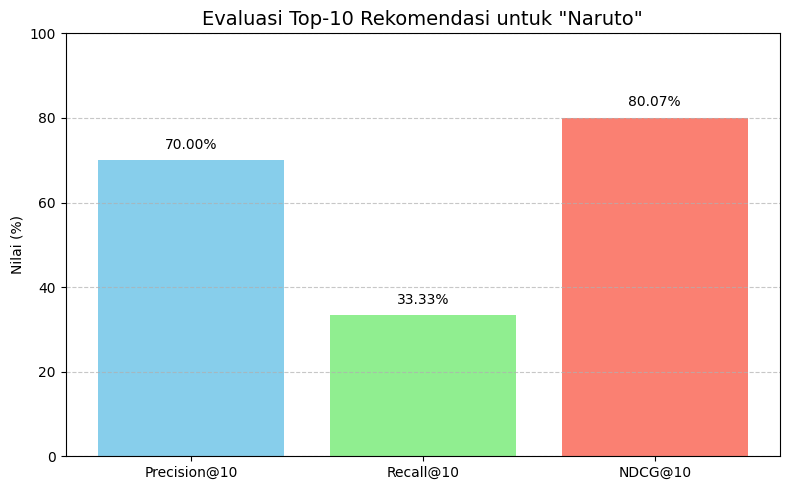

In [43]:
# Hasil Rekomendasi
recommendations = anime_recommendations("Naruto")

# Evaluasi Top-K
precision_k, recall_k, ndcg_k = evaluate_top_k(ground_truth, recommendations['name'], k=10)

# Label dan nilai
metrics = ['Precision@10', 'Recall@10', 'NDCG@10']
values = [precision_k, recall_k, ndcg_k]

# Warna pada bars
colors = ['skyblue', 'lightgreen', 'salmon']

# Plot bars
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=colors)
plt.ylim(0, 100)
plt.title('Evaluasi Top-10 Rekomendasi untuk "Naruto"', fontsize=14)
plt.ylabel('Nilai (%)')

# Menampilkan nilai pada bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- **Precision@10 sebesar 70%** menunjukkan bahwa 7 dari 10 anime yang direkomendasikan benar-benar relevan dengan preferensi pengguna

- **Recall@10 sebesar 33%** mengindikasikan bahwa dari total ground truth (23 anime), sistem berhasil menangkap sekitar sepertiganya hanya dalam 10 rekomendasi teratas.

- **NDCG@10 sebesar 80%** memperlihatkan bahwa urutan rekomendasi sangat berkualitas, di mana item-item relevan berhasil ditempatkan di posisi atas. Artinya, sistem tidak hanya merekomendasikan item yang tepat, tapi juga menyusunnya dalam urutan yang memudahkan pengguna menemukan yang paling relevan lebih dulu.

## **5. Model Development dengan Collaborative Filtering**

Model-Based Deep Learning Collaborative Filtering adalah pendekatan yang menggabungkan teknik collaborative filtering dengan metode deep learning untuk meningkatkan akurasi dan efektivitas sistem rekomendasi.

### 5.1 Data Preparation

Sebelum membangun model dengan Collaborative Filtering, kita akan melakukan data preparation terlebih dahulu diantaranya adalah :
- Penyaringan User Teraktif dan Anime Terpopuler
- Encoding anime_id dan user_id

In [44]:
# Membuat salinan untuk collaborative filtering
df_collab = full_anime_clean_data.copy()
df_collab

,user_id,anime_id,rating,name,genre,type,episodes,official_rating,members
29,1,11617,10.0,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660
31,1,11757,10.0,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
36,1,8074,10.0,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
122,1,15451,10.0,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.87,266657
154,2,11771,10.0,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25,8.46,338315
...,...,...,...,...,...,...,...,...,...
7813721,73515,3366,7.0,Persona: Trinity Soul,"Action, Sci-Fi, Super Power",TV,26,6.76,48744
7813722,73515,4835,9.0,Bleach Movie 3: Fade to Black - Kimi no Na wo Yobu,"Action, Comedy, Shounen, Super Power, Supernatural",Movie,1,7.66,122373
7813724,73515,10588,9.0,Persona 4 the Animation,"Adventure, Mystery, School, Sci-Fi, Super Power, Supernatural",TV,25,7.68,134942
7813725,73516,8074,9.0,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892


#### 5.1.1 Penyaringan User Teraktif dan Anime Terpopuler

Untuk mengurangi ukuran dataset agar lebih efisien dalam proses rekomendasi, dilakukan pemilihan subset data dengan cara mengambil user yang paling aktif dan anime yang paling populer.

Langkah ini dilakukan dengan memilih 100 user dengan jumlah rating terbanyak serta 500 anime dengan jumlah rating terbanyak. Penyaringan ini membantu mengurangi kompleksitas data tanpa mengorbankan kualitas rekomendasi.

In [45]:
# Memilih 100 user paling aktif berdasarkan jumlah rating
top_n_users = df_collab["user_id"].value_counts().index[:100]
df_collab = df_collab[full_anime_clean_data["user_id"].isin(top_n_users)]

# Memilih 500 anime terpopuler berdasarkan jumlah rating
top_m_anime = df_collab["name"].value_counts().index[:500]
df_collab = df_collab[df_collab["name"].isin(top_m_anime)]

# menampilkan dataset
df_collab

,user_id,anime_id,rating,name,genre,type,episodes,official_rating,members
152531,1530,26349,8.0,Danna ga Nani wo Itteiru ka Wakaranai Ken,"Comedy, Seinen, Slice of Life",TV,13,7.55,122271
152532,1530,26243,9.0,Owari no Seraph,"Action, Drama, Shounen, Supernatural, Vampire",TV,12,7.65,315630
152549,1530,28223,9.0,Death Parade,"Drama, Game, Mystery, Psychological, Thriller",TV,12,8.33,383914
152553,1530,28171,9.0,Shokugeki no Souma,"Ecchi, School, Shounen",TV,24,8.61,348951
152554,1530,28121,8.0,Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka,"Action, Adventure, Comedy, Fantasy, Romance",TV,13,7.88,336349
...,...,...,...,...,...,...,...,...,...
7260572,67666,11617,7.0,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660
7260573,67666,11633,8.0,Blood Lad,"Action, Comedy, Demons, Seinen, Supernatural, Vampire",TV,10,7.55,241513
7260576,67666,10521,8.0,Working&#039;!!,"Comedy, Slice of Life",TV,13,7.98,117328
7260578,67666,11703,7.0,Code:Breaker,"Action, Comedy, School, Shounen, Super Power, Supernatural",TV,13,7.03,135255


Setelah dilakukan penyaringan terhadap pengguna teraktif dan anime terpopuler berdasarkan jumlah rating, jumlah data pada dataset adalah **34501**

#### 5.1.2 Encoding anime_id dan user_id

Pada tahap ini, Kita akan melakukan encoding pada anime_id dan user_id

In [46]:
# Mengubah anime_id menjadi list tanpa nilai yang sama
anime_ids = df_collab['anime_id'].unique().tolist()
print('list anime_id: ', anime_ids)

# Melakukan encoding anime_id
anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}
print('encoded anime_id : ', anime_to_anime_encoded)

# Melakukan proses encoding angka ke ke anime_id
anime_encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}
print('encoded angka ke anime_id: ', anime_encoded_to_anime)

list anime_id:  [26349, 26243, 28223, 28171, 28121, 27899, 27655, 24439, 23847, 23755, 25183, 30276, 28701, 28907, 28497, 29803, 19221, 19369, 19769, 20541, 20507, 20031, 19815, 19775, 18277, 18247, 18229, 18153, 18115, 17895, 17831, 17729, 18671, 18897, 18893, 18753, 18679, 18677, 22729, 22535, 22319, 22297, 22199, 22147, 23281, 21327, 21085, 20973, 20847, 20787, 20785, 20689, 21881, 21431, 1689, 1686, 1691, 430, 1604, 2129, 889, 1818, 1815, 1813, 249, 245, 1015, 73, 169, 523, 269, 268, 257, 355, 857, 853, 710, 849, 846, 270, 1726, 1723, 4186, 4182, 4181, 4081, 4192, 4063, 4059, 24, 43, 50, 3956, 64, 6, 5, 1, 2025, 33, 32, 31, 4382, 4282, 4280, 4224, 4214, 2476, 2251, 2508, 1210, 861, 1889, 2593, 2605, 2104, 2034, 2026, 2167, 384, 2787, 2759, 2993, 2889, 1559, 1535, 934, 1519, 1482, 31043, 3228, 3342, 2966, 3167, 228, 226, 205, 762, 121, 120, 240, 356, 442, 237, 395, 392, 2131, 150, 777, 376, 357, 457, 7647, 7593, 7592, 7674, 7338, 7311, 7858, 8247, 8086, 8074, 7791, 7769, 7739, 7724,

In [47]:
# Mengubah user_id menjadi list tanpa nilai yang sama
user_ids = df_collab['user_id'].unique().tolist()
print('list user_id: ', user_ids)

# Melakukan encoding user_id
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded user_id : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke user_id
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke user_id: ', user_encoded_to_user)

list user_id:  [1530, 2951, 5310, 6569, 7114, 7247, 7345, 7511, 8115, 8217, 9032, 10419, 10796, 11339, 11359, 11398, 11536, 12431, 12658, 13877, 13954, 16362, 17033, 17095, 21588, 21640, 22434, 22815, 22910, 23023, 23247, 23512, 23975, 25252, 25497, 25889, 27219, 28196, 28521, 28545, 29013, 29255, 29272, 30565, 30597, 30956, 33480, 34920, 38804, 39921, 40273, 40474, 41303, 41536, 41878, 42635, 45659, 47686, 47849, 49032, 49192, 49503, 49662, 50761, 51270, 51562, 51693, 51699, 51806, 52175, 52213, 52964, 53401, 53465, 53492, 53494, 53698, 53713, 54069, 54539, 54713, 55582, 56619, 56757, 57620, 58233, 58438, 58483, 58517, 58567, 59406, 59643, 59841, 60743, 61110, 65836, 65840, 66742, 67348, 67666]
encoded user_id :  {1530: 0, 2951: 1, 5310: 2, 6569: 3, 7114: 4, 7247: 5, 7345: 6, 7511: 7, 8115: 8, 8217: 9, 9032: 10, 10419: 11, 10796: 12, 11339: 13, 11359: 14, 11398: 15, 11536: 16, 12431: 17, 12658: 18, 13877: 19, 13954: 20, 16362: 21, 17033: 22, 17095: 23, 21588: 24, 21640: 25, 22434: 26,

Setelah proses encoding selesai, kita petakan anime_id dan user_id ke dataframe yang berkaitan.

In [48]:
# Mapping anime_id ke dataframe anime
df_collab['anime'] = df_collab['anime_id'].map(anime_to_anime_encoded)

# Mapping user_id ke dataframe anime
df_collab['user'] = df_collab['user_id'].map(user_to_user_encoded)

Setelah itu kita dapat melihat jumlah user dan anime, serta melihat minimum dan maksimum pada rating

In [49]:
# Mendapatkan jumlah user
total_users = len(user_to_user_encoded)
print(total_users)

# Mendapatkan jumlah anime
total_animes = len(anime_to_anime_encoded)
print(total_animes)

# Mengubah rating menjadi nilai float
df_collab['rating'] = df_collab['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df_collab['rating'])

# Nilai maksimal rating
max_rating = max(df_collab['rating'])

print('Number of User: {}, Number of Anime: {}, Min Rating: {}, Max Rating: {}'.format(
    total_users, total_animes, min_rating, max_rating
))

100
500
Number of User: 100, Number of Anime: 500, Min Rating: 1.0, Max Rating: 10.0


Dapat kita lihat pada hasil diatas, kita memiliki 100 user, 500 anime dan rating minimim 1.0 dan rating maksimum 10.0

### 5.2 Membagi Data untuk Training dan Validasi

Pada tahap ini kita membagi data training dan data validasi untuk proses pelatihan model. Namun sebelum itu kita perlu mengacak dataset kita sehingga menjadi data yang valid.

In [50]:
# Mengacak dataset
df_collab = df_collab.sample(frac=1, random_state=42)
df_collab

,user_id,anime_id,rating,name,genre,type,episodes,official_rating,members,anime,user
4998866,47849,20787,7.0,Black Bullet,"Action, Mystery, Sci-Fi, Seinen",TV,13,7.44,320267,49,58
2395299,22910,177,6.0,Tsubasa Chronicle,"Action, Adventure, Fantasy, Magic, Romance, Shounen, Supernatural",TV,26,7.67,134705,422,28
5832239,54539,9289,7.0,Hanasaku Iroha,"Comedy, Drama, Seinen, Slice of Life",TV,26,8.03,150393,190,79
2331589,22434,21327,8.0,Isshuukan Friends.,"Comedy, School, Shounen, Slice of Life",TV,12,7.70,139601,45,26
1125793,10796,1818,9.0,Claymore,"Action, Adventure, Demons, Fantasy, Shounen, Super Power, Supernatural",TV,26,7.92,316853,61,12
...,...,...,...,...,...,...,...,...,...,...,...
4084863,38804,30,6.0,Neon Genesis Evangelion,"Action, Dementia, Drama, Mecha, Psychological, Sci-Fi",TV,26,8.32,461946,222,48
1312461,12431,150,5.0,Blood+,"Action, Drama, Horror, Military, Mystery, Supernatural, Vampire",TV,50,7.80,208321,146,17
2470105,23512,29803,8.0,Overlord,"Action, Adventure, Fantasy, Game, Magic, Supernatural",TV,13,8.04,244268,15,31
526914,5310,9047,7.0,Toaru Kagaku no Railgun: Misaka-san wa Ima Chuumoku no Mato desukara,"Action, Sci-Fi, Super Power",OVA,1,7.56,37609,211,2


Selanjutnya, kita bagi data train dan validasi dengan komposisi 80:20. Namun sebelumnya, kita perlu memetakan (mapping) data user dan anime menjadi satu value terlebih dahulu. Lalu, membuat rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training.

In [51]:
# Membuat variabel x untuk mencocokkan data user dan anime menjadi satu value
x = df_collab[['user', 'anime']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df_collab['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df_collab.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 58  49]
 [ 28 422]
 [ 79 190]
 ...
 [ 31  15]
 [  2 211]
 [ 45 126]] [0.66666667 0.55555556 0.66666667 ... 0.77777778 0.66666667 0.77777778]


### 5.3 Modeling

Pada tahap ini, model menghitung skor kecocokan antara user dan anime teknik embedding. Pertama, kita melakukan proses embedding terhadap data user dan anime. Selanjutnya, lakukan operasi perkalian dot product antara embedding user dan anime. Selain itu, kita juga dapat menambahkan bias untuk setiap user dan anime. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid

In [52]:
class RecommenderNet(Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = l2(1e-6)
    )
    self.user_bias = Embedding(num_users, 1) # layer embedding user bias
    self.anime_embedding = Embedding( # layer embeddings anime
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = l2(1e-6)
    )
    self.anime_bias = Embedding(num_anime, 1) # layer embedding anime bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    anime_vector = self.anime_embedding(inputs[:, 1]) # memanggil layer embedding 3
    anime_bias = self.anime_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_anime = tensordot(user_vector, anime_vector, 2)

    x = dot_user_anime + user_bias + anime_bias

    return sigmoid(x)

Selanjutnya, kita akan melakukan proses compile terhadap model

In [53]:
# inisialisasi model
model = RecommenderNet(total_users, total_animes, 50)

# model compile
model.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(learning_rate=0.001),
    metrics=[RootMeanSquaredError()]
)

Model ini menggunakan BinaryCrossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation.

Selanjutnya kita akan memulai proses training. Pada proses ini kita gunakan fungsi callbacks, dimana jika kinerja model tidak mengalami keanaikan maka pelatiahan dihentikan. Pada proses training parameter yang digunakan yakni batch_size=16, epoch = 50 dan verbose=1

In [54]:
# Inisialisasi Callback
callbacks = EarlyStopping(
    min_delta=0.0001,
    patience=10,
    restore_best_weights=True,
)

In [55]:
# Memulai training
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 16,
    epochs = 50,
    validation_data = (x_val, y_val),
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/50
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.6509 - root_mean_squared_error: 0.2474 - val_loss: 0.5705 - val_root_mean_squared_error: 0.1607
Epoch 2/50
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5696 - root_mean_squared_error: 0.1567 - val_loss: 0.5625 - val_root_mean_squared_error: 0.1507
Epoch 3/50
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5576 - root_mean_squared_error: 0.1425 - val_loss: 0.5566 - val_root_mean_squared_error: 0.1436
Epoch 4/50
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.5564 - root_mean_squared_error: 0.1368 - val_loss: 0.5525 - val_root_mean_squared_error: 0.1385
Epoch 5/50
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.5534 - root_mean_squared_error: 0.1335 - val_loss: 0.5517 - val_root_mean_squared_error: 0.1376
Epoch 6/50
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5515 - root_mean_squared_error: 0.1310 - val_loss: 0.5508 - val_root_mean_squared_error: 0.1368
Epoch 7/50
1725/1725 ━━━━━━━━━━━━━━━━━━

### 5.4 Pengujian Sistem Rekomendasi

Pada tahap ini kita akan melakukan pengujian dengan mengambil sampel salah satu user secara acak dari dataset, kemudian sistem akan memprediksi 10 anime terbaik yang belum ditonton oleh user tersebut berdasarkan prediksi rating tertinggi dari model.

In [56]:
# Mengambil sample user
user_id = np.random.choice(list(user_to_user_encoded.keys()))
anime_watch_by_user = ratings[ratings.user_id == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
anime_not_watch = animes_df[~animes_df['anime_id'].isin(anime_watch_by_user.anime_id.values)]['anime_id']
anime_not_watch = list(
    set(anime_not_watch)
    .intersection(set(anime_to_anime_encoded.keys()))
)

anime_not_watch = [[anime_to_anime_encoded.get(x)] for x in anime_not_watch]
user_encoder = user_to_user_encoded.get(user_id)
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watch), anime_not_watch)
)

In [57]:
# Memprediksi rating semua anime yang belum ditonton oleh user
ratings_pre = model.predict(user_anime_array).flatten()

# Mengambil indeks 10 anime dengan prediksi rating tertinggi
top_ratings_indices = ratings_pre.argsort()[-10:][::-1]

# Mendapatkan ID anime asli berdasarkan indeks yang telah diprediksi
recommended_anime_ids = [
    anime_encoded_to_anime.get(anime_not_watch[x][0]) for x in top_ratings_indices
]

# Menampilkan ID pengguna yang dipilih
print('Rekomendasi Anime untuk Pengguna dengan ID: {}'.format(user_id))
print()
print('----' * 20)
print('Anime dengan rating tertinggi untuk pengguna:')
print('----' * 20)

# Menampilkan 5 anime terbaik yang telah ditonton user berdasarkan rating tertinggi
top_anime_user = (
    anime_watch_by_user.sort_values(
        by='rating',
        ascending=False
    )
    .head(5)
    .anime_id.values
)

# Menampilkan informasi anime yang telah ditonton dengan rating tertinggi
anime_df_rows = animes_df[animes_df['anime_id'].isin(top_anime_user)]
for row in anime_df_rows.itertuples():
    print(row.name, ':', row.genre)

print()
print('----' * 20)
print('Rekomendasi 10 Anime Terbaik:')
print('----' * 20)

# Menampilkan daftar rekomendasi 10 anime terbaik untuk user berdasarkan prediksi model
no = 1
recommended_anime = animes_df[animes_df['anime_id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print('----' * 20)
    print('No         :', no)
    print('Nama Anime  :', row.name)
    print('Genre      :', row.genre)
    print('----' * 20)
    no += 1

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Rekomendasi Anime untuk Pengguna dengan ID: 27219

--------------------------------------------------------------------------------
Anime dengan rating tertinggi untuk pengguna:
--------------------------------------------------------------------------------
Cowboy Bebop : Action, Adventure, Comedy, Drama, Sci-Fi, Space
Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen : Action, Drama, Historical, Martial Arts, Romance, Samurai
Rurouni Kenshin: Meiji Kenkaku Romantan : Action, Adventure, Comedy, Historical, Romance, Samurai
Arakawa Under the Bridge x Bridge : Comedy, Romance, Seinen
Steins;Gate : Sci-Fi, Thriller

--------------------------------------------------------------------------------
Rekomendasi 10 Anime Terbaik:
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
No         : 1
Nama Anime  : Mononoke Hime
Genre      : Action,

### 5.5 Evaluation

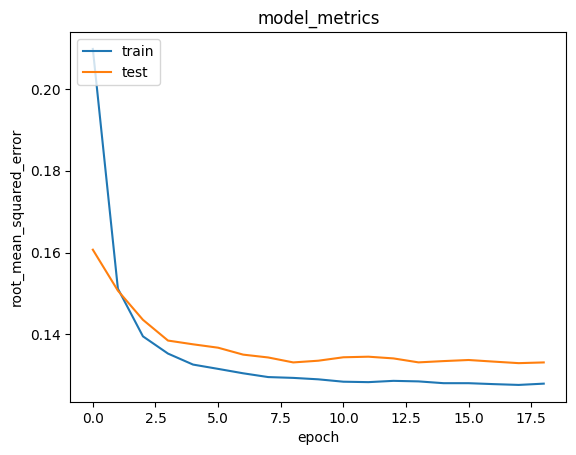

In [58]:
# Visualisasi metrik
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Evaluasi performa model dilakukan menggunakan metrik Root Mean Squared Error (RMSE) pada data pelatihan dan validasi. Berdasarkan hasil training yang dilakukan hingga epoch ke-25, nilai root_mean_squared_error pada data pelatihan tercatat berada sedikit di atas 0.126, sedangkan pada data validasi sedikit di bawah 0.133.